In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [4]:
PathWindows = r"D:\Учеба\Практика\Диплом\gamma"
LibraryPathWindows = r"D:\Учеба\Практика\Диплом\gamma\SpectrumsMeasurementsLibrary"
LibraryPathLinux = r"/home/danis/work/python_works/gamma"
sys.path.insert(0, LibraryPathWindows)
sys.path.insert(0, PathWindows)
sys.path.insert(0, LibraryPathLinux)

In [5]:
from GammaRayInteractions.Materials import Material, R
from CrossSectionsLibrary.cross_sections_data import ENERGY_MESH
from MeasurementInstrumentation.measurement_techniques import ideal_transmission_function, \
k_edge_method_transmission_function, ross_method_transmission_function, edges_indices
from NumericalMethods.simpson_rule import simpson_rule
from NumericalMethods.unfolding_technique import Gold

In [6]:
brem = R(50, 1e-2).emitted_bremsstrahlung(0.075)

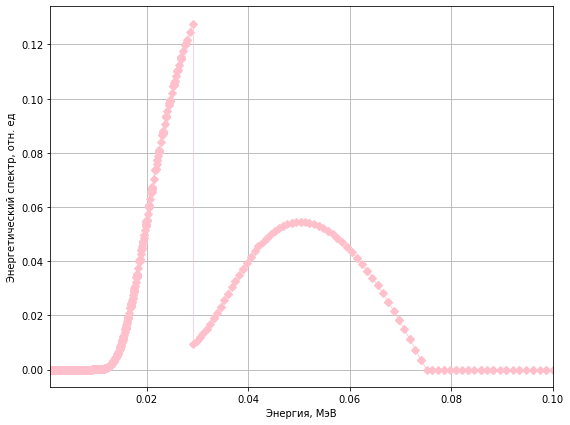

In [7]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(ENERGY_MESH, brem, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

In [8]:
first_channel = 11
last_channel = 100 
number_of_channels = last_channel - first_channel
number_of_channels_with_open_detector = 1

In [9]:
level = 0.1

In [10]:
EDGE_METHOD_channels = [k_edge_method_transmission_function(num, level) for num in range(first_channel, last_channel+1)]
IDEAL_channels = [ideal_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]
ROSS_METHOD_channels = [ross_method_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]

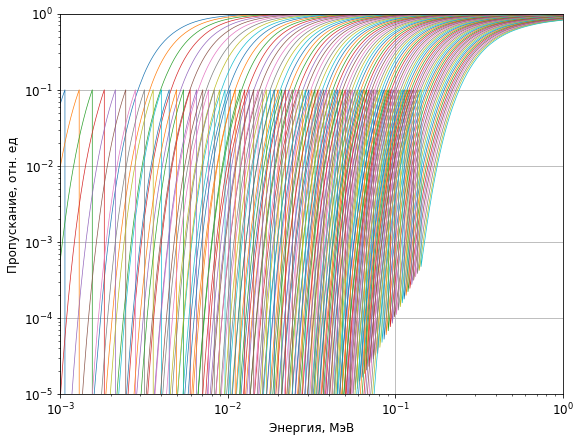

In [11]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in EDGE_METHOD_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-3, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

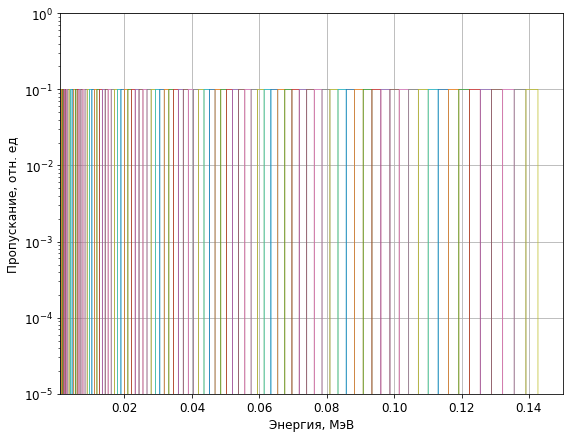

In [12]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in IDEAL_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-3, 0.15e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

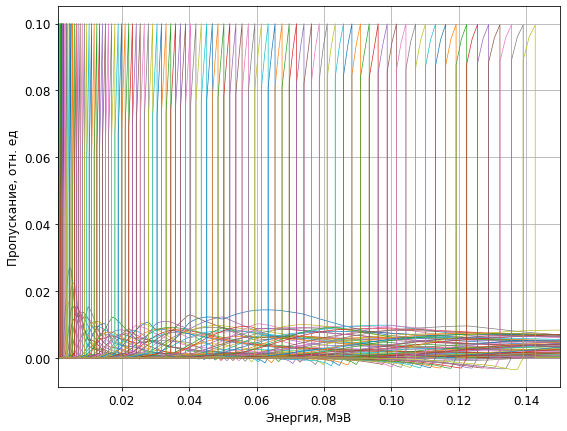

In [13]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in ROSS_METHOD_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlim(1e-3, 0.15e0)
# ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

In [14]:
signals_simpson = [simpson_rule(brem*r) for r in EDGE_METHOD_channels]

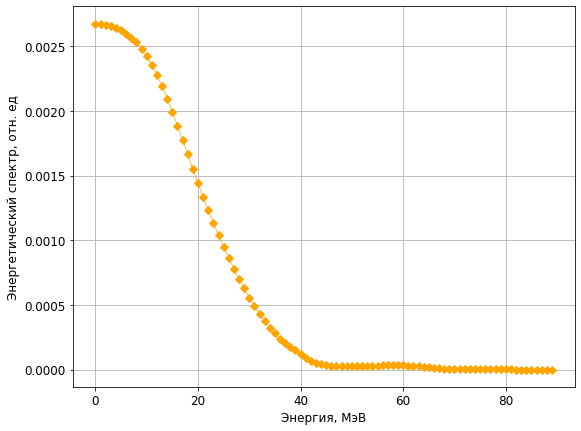

In [15]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(list(range(len(signals_simpson))), signals_simpson, ls='-', marker='D', lw='0.7', ms=5, color='orange')
# ax.plot(e3, mean_spectrum, ls='-', marker='D', lw='0.7', ms=5, color='orange')
# ax.plot(en, brem_e, ls='-', marker='D', lw='0.7', ms=5, color='pink')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

In [16]:
Matrix = np.array([simpson_rule(r, regime='c', function_jumps=[1541]) for r in EDGE_METHOD_channels])

In [17]:
new_mesh = np.array(simpson_rule(EDGE_METHOD_channels[0], regime='m', function_jumps=[1541]))

In [18]:
sp = [0 for i in range(len(signals_simpson))]
norm = [0 for i in range(len(signals_simpson))]
decb = [0 for i in range(len(signals_simpson))]
dev = [0 for i in range(len(signals_simpson))]

In [19]:
def Gold(A, b, en, init_spectrum, dec_en, x0=False, it=None, w=False, d=False):
    A = np.array(A)
    b = np.array(b)
    b = b.reshape(len(b), -1)

    def deviation(init_spectrum, dec_spectrum):
        dec_spectrum_on_init_grid = np.interp(en, dec_en, dec_spectrum)
        different = [(i - j) ** 2 for i, j in zip(dec_spectrum_on_init_grid, init_spectrum)]
        init_sq = [val ** 2 for val in init_spectrum]

        def integral_t(different_signal, grid):
            s = 0
            for i in range(1, len(different_signal) - 2):
                s += (grid[i] - grid[i - 1]) * different_signal[i - 1]
            return s

        dev = integral_t(different, en) / integral_t(init_sq, en)
        return dev

    # Если начальное приближение не задано создает вектор-столбец x0 = [1, 1,.., 1]
    if x0:
        previous_x = np.ones((A.shape[1], 1), dtype=np.float64)
    # Транспонирование вектора х0, если он считывается вектором-строкой
    else:
        x0 = float(input('Введите начальное приближение: '))
        previous_x = x0 * np.ones((A.shape[1], 1), dtype=np.float64)
    # Транспонирование вектора b, если он считывается вектором-строкой
    if b.shape[1] != 1:
        b = b.T
    if it is None:
        num_of_iter = int(input('Введите число итераций: '))
    else:
        num_of_iter = it

    if w == False:
        W = np.diag([float(1 ** 2) for i in range(0, len(b))])
    if w == True:
        W = np.diag([float(i) for i in range(0, len(b))])

    current_x = np.ones((A.shape[1], 1), dtype=np.float64)
    norm_list = []
    deviation_list = []

    # Основной цикл алгоритма Голда
    for k in range(0, num_of_iter + 1):
        # Создание матрицы Y = A.T * W.T * W * b
        Y = np.dot(A.T, np.dot(W.T, np.dot(W, b)))
        # Создание матрицы AX = A.T * W.T * W * A * x
        AX = np.dot(A.T, np.dot(W.T, np.dot(W, np.dot(A, previous_x))))
        AX[AX == 0] = np.nextafter(0, 1)*1e20
        current_x = 1.0 * previous_x + (previous_x / AX) * (Y - AX)
        previous_x = current_x

        norm_list.append(np.linalg.norm(np.dot(A, current_x) - b))
        if d == True:
            deviation_list.append(deviation(init_spectrum, current_x.reshape(1, -1)[0].tolist()) ** 0.5)

    norm = [range(1, num_of_iter + 2), norm_list]

    if d == True:
        dev = [range(1, num_of_iter + 2), deviation_list]
    if d == False:
        dev = deviation(init_spectrum, current_x.reshape(1, -1)[0].tolist())**0.5


    current_x = current_x.reshape(1, -1)
    current_x = current_x[0].tolist()

    return current_x, norm, dev

In [20]:
def deviation(init_spectrum, dec_spectrum):
        dec_spectrum_on_init_grid = np.interp(en, dec_en, dec_spectrum)
        different = [(i - j) ** 2 for i, j in zip(dec_spectrum_on_init_grid, init_spectrum)]
        init_sq = [val ** 2 for val in init_spectrum]

        def integral_t(different_signal, grid):
            s = 0
            for i in range(1, len(different_signal) - 2):
                s += (grid[i] - grid[i - 1]) * different_signal[i - 1]
            return s

        dev = integral_t(different, en) / integral_t(init_sq, en)
        return dev

In [21]:
def get_deviation(initial_mesh, initial_spectrum, deconvolved_mesh, deconvolved_spectrum):
    """
    Возвращает ошибку восстановления спектра
    """
    deconvolved_spectrum_on_initial_mesh = np.interp(initial_mesh, deconvolved_mesh, deconvolved_spectrum)
    unfolding_deviation = (initial_spectrum - deconvolved_spectrum_on_initial_mesh)**2
    
    return simpson_rule(unfolding_deviation) / simpson_rule(initial_spectrum**2)


def get_deviation_up_to_bound(initial_mesh, initial_spectrum, deconvolved_mesh, deconvolved_spectrum, bound):
    """
    Возвращает ошибки восстановления спектра в области до К скачка 100 элемента таблицы Менделеева
    """
    deconvolved_spectrum_on_initial_mesh = np.interp(initial_mesh, deconvolved_mesh, deconvolved_spectrum)
    initial_spectrum_up_to_bound = np.copy(initial_spectrum)
    deconvolved_spectrum_up_to_bound = np.copy(deconvolved_spectrum_on_initial_mesh)
    initial_spectrum_up_to_bound[bound:] = 0 # зануление части, лежащей выше требуемого К скачка
    deconvolved_spectrum_up_to_bound[bound:] = 0 # зануление части, лежащей выше требуемого К скачка
    unfolding_deviation = (initial_spectrum_up_to_bound - deconvolved_spectrum_up_to_bound)**2
    
    return simpson_rule(unfolding_deviation) / simpson_rule(initial_spectrum_up_to_bound**2)

In [22]:
bound_100_kev = Material(100).k_edge_index()

In [23]:
def Gold(matrix, results, weight, initial_mesh, deconvolved_mesh, initial_spectrum, iteration_number, bound, journal=False):
    A, b = matrix, results
    W = np.diag([float(i**weight) for i,val in enumerate(b)])
    previous_x = np.ones((A.shape[1])) # начальное приближение
    current_x = np.ones((A.shape[1])) # текущее значение
    
    signals_deviation = np.empty(iteration_number) # пустой массив под запись отклонения сигналов на каждой итерации
    unfolding_deviation = np.empty(iteration_number) # пустой массив под запись ошибки восстановления спектра
    unfolding_deviation_up_to_100_kev = np.empty(iteration_number) # пустой массив под запись ошибки восстановления спектра до 100 кэв
    
    bound_100_kev = bound
    
    if journal == False:
        # Основной цикл алгоритма Голда
        for k in range(0, iteration_number + 1):
            # Создание матрицы Y = A.T * W.T * W * b
            Y = np.dot(A.T, np.dot(W.T, np.dot(W, b)))
            # Создание матрицы AX = A.T * W.T * W * A * x
            AX = np.dot(A.T, np.dot(W.T, np.dot(W, np.dot(A, previous_x))))
            AX[AX == 0] = np.nextafter(0, 1)*1e20
            current_x = previous_x + (previous_x / AX) * (Y - AX)
            previous_x = current_x
        
        unfolding_deviation = get_deviation(initial_mesh, initial_spectrum, deconvolved_mesh, current_x)
        unfolding_deviation_up_to_100_kev = get_deviation_up_to_bound(initial_mesh, initial_spectrum, deconvolved_mesh, current_x, bound_100_kev)
        signals_deviation = np.linalg.norm(np.dot(A, current_x) - b)
        
        return current_x, unfolding_deviation, unfolding_deviation_up_to_100_kev, signals_deviation
    
    
    if journal == True:
        
        # Основной цикл алгоритма Голда
        for k in range(0, iteration_number):
            # Создание матрицы Y = A.T * W.T * W * b
            Y = np.dot(A.T, np.dot(W.T, np.dot(W, b)))
            # Создание матрицы AX = A.T * W.T * W * A * x
            AX = np.dot(A.T, np.dot(W.T, np.dot(W, np.dot(A, previous_x))))
            AX[AX == 0] = np.nextafter(0, 1)*1e20
            current_x = previous_x + (previous_x / AX) * (Y - AX)
            previous_x = current_x
            
            signals_deviation[k] = np.linalg.norm(np.dot(A, current_x) - b)
            unfolding_deviation[k] = get_deviation(initial_mesh, initial_spectrum, deconvolved_mesh, current_x)
        
    return current_x, [list(range(iteration_number)), signals_deviation, unfolding_deviation]

In [24]:
sp = Gold(Matrix, signals_simpson, 2, ENERGY_MESH, new_mesh, brem, iteration_number=10000, bound=bound_100_kev, journal=False)

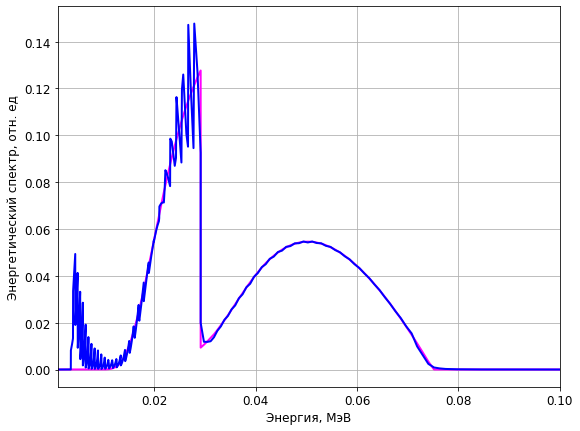

In [25]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(ENERGY_MESH, brem, ls='-', lw='2', ms=5, color='magenta')
ax.plot(new_mesh, sp[0], ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 0.5)
ax.grid(True)

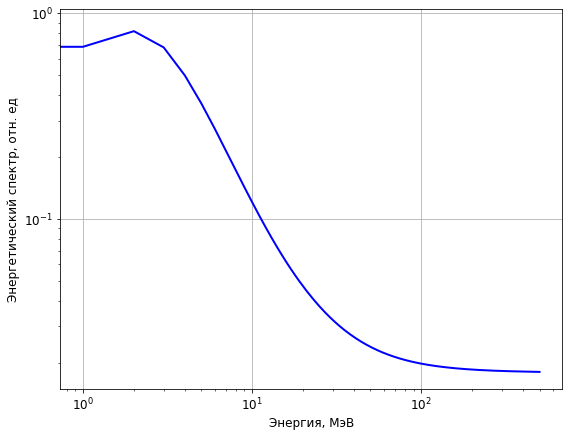

In [332]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(sp[1][0], sp[1][2], ls='-', lw='2', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1e-3, 0.10e0)
# ax.set_ylim(1e-7, 0.5)
ax.grid(True)